In [1]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

batch_size = 16
epochs = 5

using cpu device.


In [2]:
data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
print(str(data_root))
image_path = "./flower_data"
#image_path = os.path.join(data_root,"Users\Administrator\PycharmProjects\pythonProject3\MobileNet", "flower_data")
assert os.path.exists(image_path),"file: '{}' does not exist.".format(image_path)

nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

C:\Users\Administrator\PycharmProjects
Using 8 dataloader workers every process


In [3]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.RandomResizedCrop(256), 
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

train_dir = os.path.join(image_path, "train")
val_dir = os.path.join(image_path, "val")

train_dataset = datasets.ImageFolder(train_dir, transform=data_transform["train"])
train_num = len(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=nw)

validate_dataset = datasets.ImageFolder(val_dir, transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=nw)
print("using {} images for training, {} images for validation.".format(train_num, val_num))

using 2572 images for training, 1098 images for validation.


In [4]:
# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

In [5]:
def _make_divisible(ch, divisor = 8, min_ch=None):
    
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch, int(ch + divisor /  2) // divisor * divisor)
    
    if new_ch < 0.9 * ch:
        new_ch += divisor
    return new_ch

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
        
class InvertedResidual(nn.Module):
    def __init__(self, in_channel, out_channel, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_channel = in_channel * expand_ratio
        self.use_shortcut = stride == 1 and in_channel == out_channel
        
        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(in_channel, hidden_channel, kernel_size=1))
        layers.extend([
            ConvBNReLU(hidden_channel, hidden_channel, stride=stride, groups=hidden_channel),
            nn.Conv2d(hidden_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel),
        ])
        
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv(x)
        else: 
            return self.conv(x)
        
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, alpha=1.0, round_nearest=8):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = _make_divisible(32 * alpha, round_nearest)
        last_channel = _make_divisible(1280 * alpha, round_nearest)
        
        inverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        
        features = []
        features.append(ConvBNReLU(3, input_channel, stride=2))
        
        for t, c, n, s in inverted_residual_setting:
            out_channel = _make_divisible(c * alpha, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, out_channel, stride, expand_ratio=t))
                input_channel = out_channel
                
        features.append(ConvBNReLU(input_channel, last_channel, 1))
        
        self.features = nn.Sequential(*features)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes)
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
net = MobileNetV2(num_classes=5)

In [6]:
model_weight_path = "./mobilenet_v2.pth"
assert os.path.exists(model_weight_path),"file:'{}' does not exist.".format(model_weight_path)
pre_weights = torch.load(model_weight_path, map_location='cpu')

pre_dict = {k: v for k, v in pre_weights.items() if net.state_dict()[k].numel() == v.numel()}
missing_keys, unexpected_keys = net.load_state_dict(pre_dict, strict=False)
for param in net.features.parameters():
    param.requires_grad = False

In [11]:
net.to(device)
loss_function = nn.CrossEntropyLoss()

params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

best_acc = 0.0
save_path = './MobileNetV2.pth'
train_steps = len(train_loader)

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_bar.desc = "train epoc[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)


    net.eval()
    acc = 0.0
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

            val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epochs)

    val_accurate = acc / val_num
    print('[epoch {}] train_loss:{:.3f} val_accuracy:{:.3f}'.format(epoch +1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')

valid epoch[1/5]: 100%|██████████| 69/69 [00:51<00:00,  1.33it/s]
[epoch 1] train_loss:0.607 val_accuracy:0.847
valid epoch[2/5]: 100%|██████████| 69/69 [00:54<00:00,  1.27it/s]
[epoch 2] train_loss:0.562 val_accuracy:0.846
valid epoch[3/5]: 100%|██████████| 69/69 [00:52<00:00,  1.32it/s]
[epoch 3] train_loss:0.538 val_accuracy:0.854
valid epoch[4/5]: 100%|██████████| 69/69 [00:50<00:00,  1.37it/s]
[epoch 4] train_loss:0.516 val_accuracy:0.876
valid epoch[5/5]: 100%|██████████| 69/69 [00:50<00:00,  1.36it/s]
[epoch 5] train_loss:0.504 val_accuracy:0.874
Finished Training


class: daisy      prob: 0.0106
class: dandelion  prob: 0.963
class: roses      prob: 0.00178
class: sunflowers prob: 0.021
class: tulips     prob: 0.00324


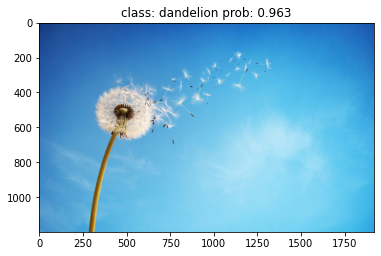

In [14]:
img_path  = "./flower.jpg"
assert os.path.exists(img_path),"file:'{}' does noet exist".format(img_path)
img = Image.open(img_path)
plt.imshow(img)
img = data_transform["val"](img)
img = torch.unsqueeze(img, dim=0)

json_path = "./class_indices.json"
assert os.path.exists(json_path),"file:{} does not exist".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

model = MobileNetV2(num_classes=5).to(device)
model_weight_path = "./MobileNetV2.pth"
model.load_state_dict(torch.load(model_weight_path, map_location=device))
model.eval()
with torch.no_grad():
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {} prob: {:.3}".format(class_indict[str(predict_cla)],
                                           predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10} prob: {:.3}".format(class_indict[str(i)],
                                            predict[i].numpy()))
plt.show()
